# Классификация с помощью kNN. Кластеризация K-means

#### 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов. 

В рамках этого задания была изменена функция knn (добавлены веса)

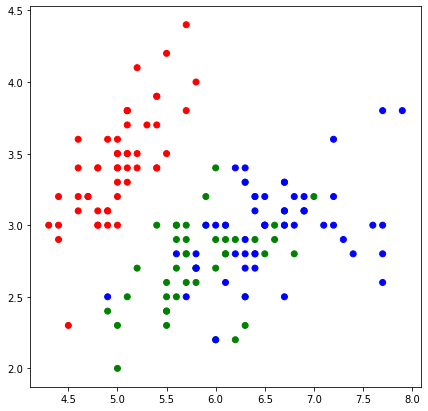

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap


X, y = load_iris(return_X_y=True)
# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [7]:
# Используем евклидову метрику. Реализуем функцию для ее подсчета.

def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

# Напишем функцию для вычисления точности.

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Реализуем алгоритм поиска k ближайших соседей c весами.

In [92]:
def knn(x_train, y_train, x_test, k, q):  #Добавлено q - устанавливаемое при запуске функции вручную
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes= {class_item: 0 for class_item in set(y_train)}

        # Сортируем список и среди первых k элементов, посчитаем сумму весов классов ближайших соседей
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += q ** d[0]  # Вместо прибавления 1, прибавляем вес признака в словарь по ближайшим соседям
#        print(classes)    

#        print(sorted(classes, key=classes.get)[-1])    
        # Записываем в список ответов класс, который по сумме весов оказывает большее влияние на соседа
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Проверим работу алгоритма при различных k

In [93]:
k = 10

y_pred = knn(X_train, y_train, X_test, k, 0.5)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.867


Точность:

k = 2: была 0.667, стала 0.733

k = 3:  была 0.733, стала 0.733

k = 4: была 0.833, стала 0.767

k = 5: была 0.867, стала 0.867

k = 10: была 0.833, стала 0.867

По идее при увеличении количества K в алгоритме без весов точность становится все менее информативной и более непредсказумой, в отличии от алгоритма с весами, т.к. прибавляются объекты, которые дальше, но с маленьким и невлияющим весом

## Обучение без учителя. Кластеризация. K-means

#### 2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

В рамках этого задания была создана функция quality и построен график зависимости антикачества от количества кластеров с 4 линиями зависимости от количества итераций

In [2]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

In [3]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [20]:
def quality(centroids, clusters):  # внутрикластерное расстояние нужно минимизировать
    clasters_dist = 0  
    for key in clusters.keys():  # пробегаемся по словарю (по кластерам), в котором точки уже были разбиты по кластерам
        claster_dist = 0
        for point in clusters[key]: # пробегаемся по каждой точке в словаре, чтобы посчитать расстояние этой точки до центроиды
            claster_dist += np.square(e_metrics(centroids[key], point)) # расстояние возводим в квадрат и суммируем
        clasters_dist += claster_dist/len(clusters[key]) # среднее квадратичное расстояние суммируем по каждому кластеру
    return round(clasters_dist, 2)

In [21]:
# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4
# сразу определим известное нам количество кластеров
k = 3

In [22]:
max_iterations = 1
gualities_1 = []
for k_i in range(1, 11):
    gualities_1.append(quality(*kmeans(X, k_i, max_iterations, min_distance)))
print(max_iterations, gualities_1)
max_iterations = 3
gualities_3 = []
for k_i in range(1, 11):
    gualities_3.append(quality(*kmeans(X, k_i, max_iterations, min_distance)))
print(max_iterations, gualities_3)
max_iterations = 5
gualities_5 = []
for k_i in range(1, 11):
    gualities_5.append(quality(*kmeans(X, k_i, max_iterations, min_distance)))
print(max_iterations, gualities_5)
max_iterations = 10
gualities_10 = []
for k_i in range(1, 11):
    gualities_10.append(quality(*kmeans(X, k_i, max_iterations, min_distance)))
print(max_iterations, gualities_10)

1 [89.33, 18.47, 21.71, 24.15, 16.92, 13.02, 13.88, 14.52, 12.53, 10.39]
3 [41.18, 10.88, 4.7, 4.96, 4.79, 5.7, 5.49, 5.72, 6.05, 6.2]
5 [41.18, 10.88, 4.68, 4.83, 4.72, 5.69, 5.48, 5.62, 5.92, 5.91]
10 [41.18, 10.88, 4.68, 4.83, 4.72, 5.69, 5.48, 5.62, 5.92, 5.7]


1. После 3 кластеров график вышел на асимптоту
2. при большем количестве итераций качество растет 

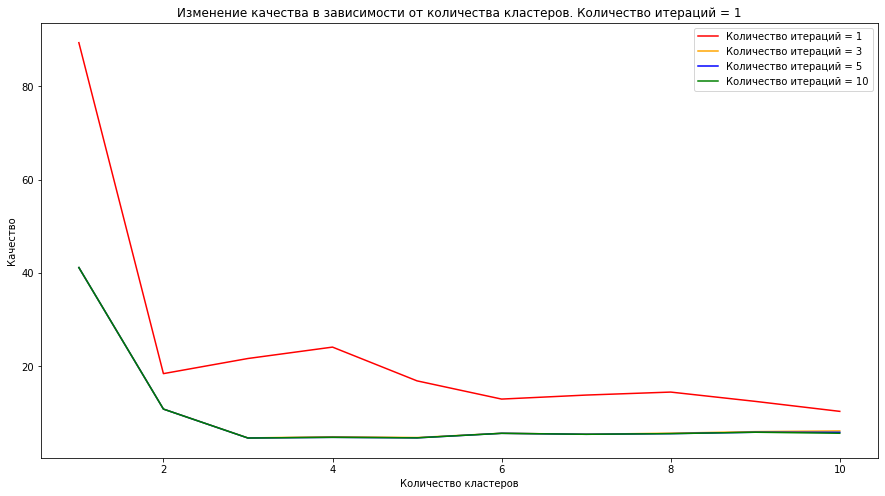

In [23]:
fig = plt.figure(figsize=(15,8))
plt.title('Изменение качества в зависимости от количества кластеров. Количество итераций = 1')
plt.xlabel('Количество кластеров')
plt.ylabel('Качество')
plt.plot([i for i in range(1, 11)], gualities_1, color='r', label='Количество итераций = 1')
plt.plot([i for i in range(1, 11)], gualities_3, color='orange', label='Количество итераций = 3')
plt.plot([i for i in range(1, 11)], gualities_5, color='b', label='Количество итераций = 5')
plt.plot([i for i in range(1, 11)], gualities_10, color='g', label='Количество итераций = 10')
plt.legend()